## 1. Data Loading and Overview

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss


df = pd.read_csv("heart_processed.csv")
df.shape


(918, 16)

## 2. Exploratory Data Analysis


In [4]:
df.isnull().sum().sort_values(ascending=False)

,0
Age,0
RestingBP,0
Cholesterol,0
FastingBS,0
MaxHR,0
Oldpeak,0
HeartDisease,0
Sex_M,0
ChestPainType_ATA,0
ChestPainType_NAP,0


In [6]:

df["HeartDisease"].value_counts(normalize=True)


,proportion
HeartDisease,
1,0.553377
0,0.446623


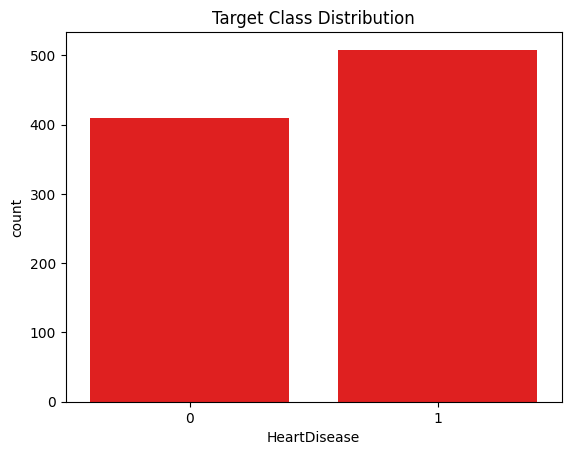

In [7]:
sns.countplot(x="HeartDisease", data=df,color='red')
plt.title("Target Class Distribution")
plt.show()


In [8]:
corr = df.corr()

top_corr = corr["HeartDisease"].abs().sort_values(ascending=False)[1:11]
top_corr


,HeartDisease
ST_Slope_Up,0.622164
ST_Slope_Flat,0.554134
ExerciseAngina_Y,0.494282
Oldpeak,0.403951
ChestPainType_ATA,0.401924
MaxHR,0.400421
Sex_M,0.305445
Age,0.282039
FastingBS,0.267291
Cholesterol,0.232741


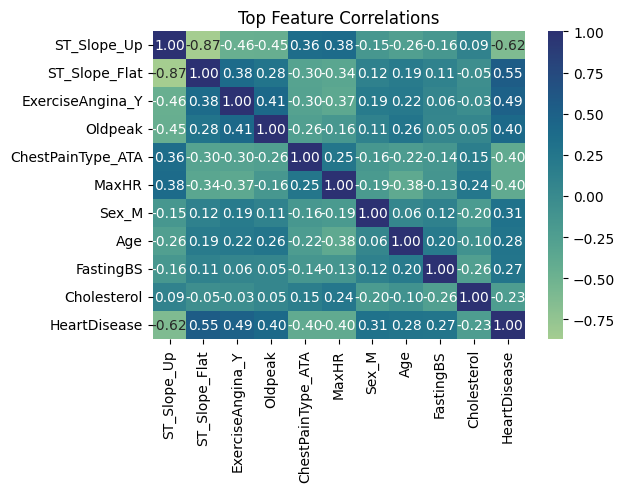

In [9]:
plt.figure(figsize=(6,4))
sns.heatmap(df[top_corr.index.tolist() + ["HeartDisease"]].corr(),
            annot=True, cmap="crest", fmt=".2f")
plt.title("Top Feature Correlations")
plt.show()


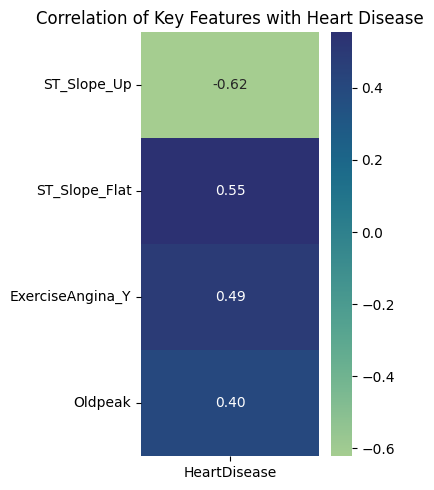

In [10]:
top_features = [
    "ST_Slope_Up",
    "ST_Slope_Flat",
    "ExerciseAngina_Y",
    "Oldpeak"
]
plt.figure(figsize=(4,5))
sns.heatmap(
    corr.loc[top_features, ["HeartDisease"]],
    annot=True,
    cmap="crest",
    fmt=".2f",
    cbar=True
)
plt.title("Correlation of Key Features with Heart Disease")
plt.tight_layout()
plt.show()



## 3. Baseline Model: Logistic Regression


In [ ]:


X = df.drop(columns=["HeartDisease"])
y = df["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:

y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_prob)

print("ROC-AUC:", roc_auc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

ROC-AUC: 0.9311334289813487

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.83      0.87        82
           1       0.87      0.93      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184


Confusion Matrix:
 [[68 14]
 [ 7 95]]


In [ ]:
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lr.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

coef_df


,Feature,Coefficient
6,Sex_M,1.106449
13,ST_Slope_Flat,0.983074
3,FastingBS,0.927444
12,ExerciseAngina_Y,0.905420
5,Oldpeak,0.274131
0,Age,0.003609
1,RestingBP,0.002049
2,Cholesterol,-0.004587
4,MaxHR,-0.007843
11,RestingECG_ST,-0.317013


## 4. Random Forest Model


In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                       n_estimators=300, n_jobs=-1, random_state=42)

In [ ]:
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

roc_auc_rf = roc_auc_score(y_test, y_prob_rf)

print("Random Forest ROC-AUC:", roc_auc_rf)
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Random Forest ROC-AUC: 0.9346006695361072

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88        82
           1       0.89      0.91      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184


Confusion Matrix:
 [[71 11]
 [ 9 93]]


In [ ]:
feat_imp = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

feat_imp.head(10)

,Feature,Importance
14,ST_Slope_Up,0.205435
13,ST_Slope_Flat,0.137250
5,Oldpeak,0.106220
4,MaxHR,0.100228
2,Cholesterol,0.092444
12,ExerciseAngina_Y,0.089870
0,Age,0.061552
1,RestingBP,0.056361
7,ChestPainType_ATA,0.041828
6,Sex_M,0.034738


/tmp/ipython-input-3569053748.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


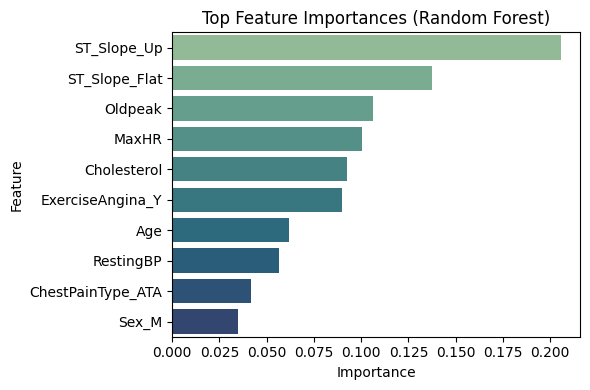

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feat_imp.head(10),
    palette="crest"
)
plt.title("Top Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

## 5. Model Interpretability (SHAP)


In [ ]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)


In [ ]:
type(shap_values), np.array(shap_values).shape


(numpy.ndarray, (184, 15, 2))

In [ ]:

shap_values_class1 = shap_values[:, :, 1]


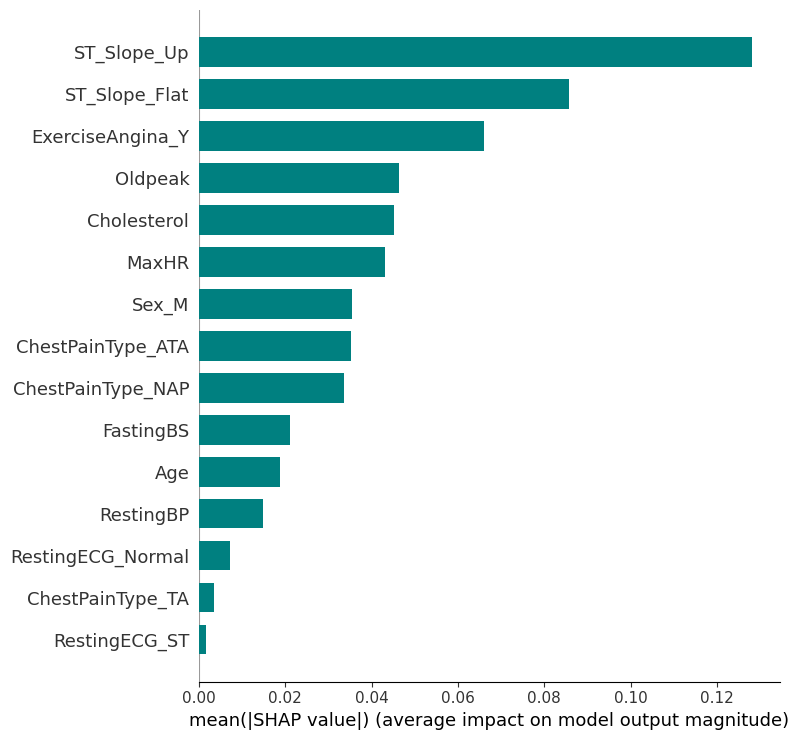

In [ ]:
shap.summary_plot(
    shap_values_class1,
    X_test,
    color='teal',
    plot_type="bar",
    show=True
)



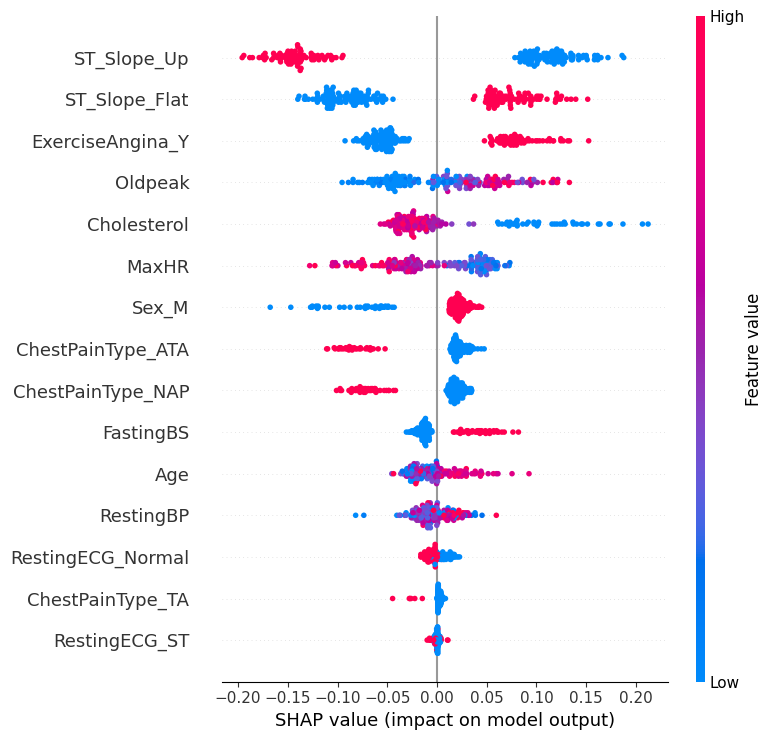

In [ ]:
shap.summary_plot(
    shap_values_class1,
    X_test,
    show=True
)


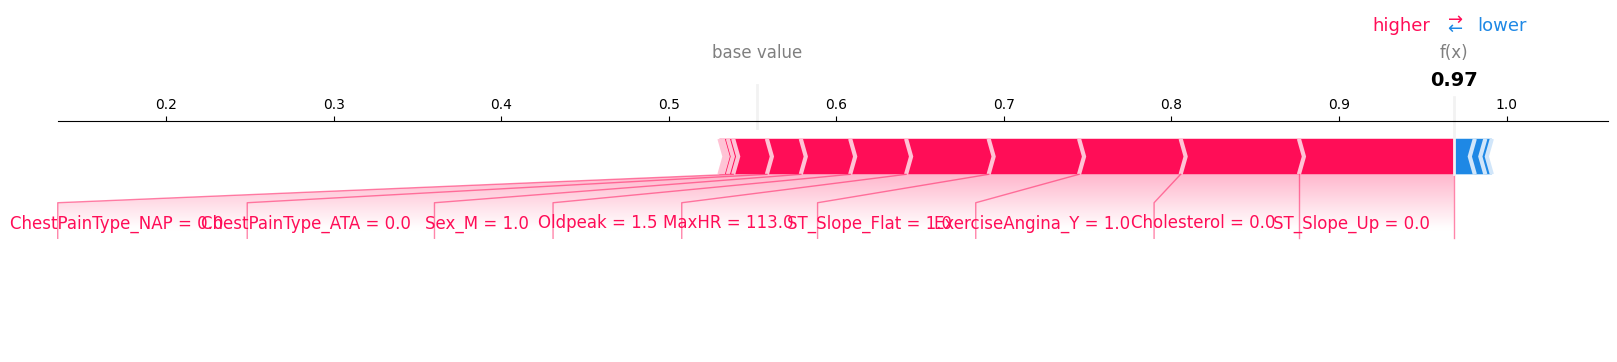

In [ ]:
i = 0  # index of a test sample

shap.force_plot(
    explainer.expected_value[1],
    shap_values_class1[i],
    X_test.iloc[i],
    matplotlib=True
)


## 6. Risk Stratification and Calibration


In [ ]:
def risk_category(p):
    if p < 0.33:
        return "Low Risk"
    elif p < 0.66:
        return "Medium Risk"
    else:
        return "High Risk"

risk_labels = pd.Series(y_prob_rf).apply(risk_category)


In [ ]:
risk_labels.value_counts(normalize=True)


,proportion
High Risk,0.500000
Low Risk,0.331522
Medium Risk,0.168478


In [ ]:
risk_df = pd.DataFrame({
    "TrueLabel": y_test.values,
    "RiskGroup": risk_labels.values
})

pd.crosstab(risk_df["RiskGroup"], risk_df["TrueLabel"], normalize="index")


TrueLabel,0,1
RiskGroup,,
High Risk,0.086957,0.913043
Low Risk,0.934426,0.065574
Medium Risk,0.548387,0.451613


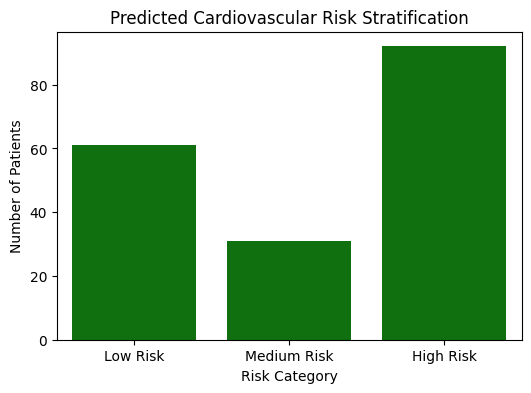

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x=risk_labels, order=["Low Risk", "Medium Risk", "High Risk"],color="green")
plt.title("Predicted Cardiovascular Risk Stratification")
plt.xlabel("Risk Category")
plt.ylabel("Number of Patients")
plt.show()


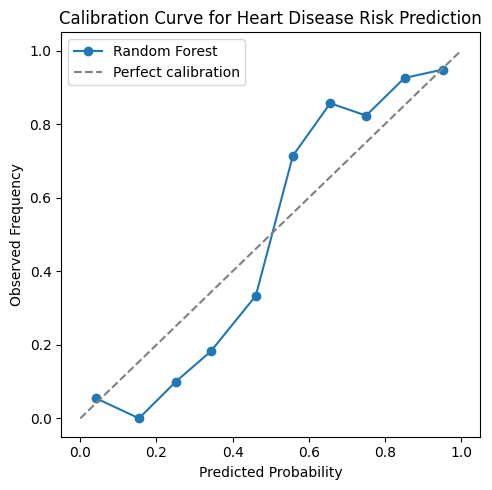

In [ ]:
prob_true, prob_pred = calibration_curve(
    y_test, y_prob_rf, n_bins=10, strategy="uniform"
)

plt.figure(figsize=(5,5))
plt.plot(prob_pred, prob_true, marker='o', label="Random Forest")
plt.plot([0,1], [0,1], linestyle='--', color='gray', label="Perfect calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curve for Heart Disease Risk Prediction")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
brier = brier_score_loss(y_test, y_prob_rf)
brier

np.float64(0.09928881112051174)